# Algorithme EM

In [5]:
%matplotlib inline
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc

/Users/aurianeblarre/miniconda3/lib/python3.4/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [6]:
def sigma(z):
    return 1/(1+np.exp(-z))

In [13]:
class model:
    """Classe qui encapsule l'apprentissage"""
    
    def __init__(self, D, R):
        """Constructeur"""
        
        self.D = D #Nombre de variables explicatives
        self.R = R #Nombre d'annotateurs
     
    
    def chargeData(self, path, recentrage = True):
        """Fonction qui charge les données avec path le chemin du fichier CSV. 
        Par default, on impose un recentrage des donnees"""
        
        data = pd.read_csv(path, delimiter = ";")
        self.trueLabel = np.array(data.ix[:,self.D])
        self.y = np.array(data.ix[:,self.D+1:]) #labels des annotateurs
        x = np.array(data.ix[:,0:self.D]) #variables explicatives
        if (recentrage):
            self.x = (x -np.mean(x,axis=0))/(np.std(x, axis=0))
        else:
            self.x = x
        self.N = self.y.shape[0] #Nombre de lignes
     
    
    def initMu(self):
        """Initialisation de mu"""
        
        self.mu = []
        for i in range(0,self.N):
            self.mu.append(np.sum(self.y[i])/self.R)
    
    
    def ai(self):
        """Update du vecteur a (1xN)"""
        
        a = []
        for i in range(0,self.N):
            proda = 1
            for j in range(0,self.R):
                proda = proda*self.alpha[j]**(self.y[i][j])*(1-self.alpha[j])**(1-self.y[i][j])
            a.append(proda)
        self.a = a
    
    
    def bi(self):
        """Update du vecteur b (1xN)"""
        
        b = []
        for i in range(0,self.N):
            prodb = 1
            for j in range(0,self.R):
                prodb = prodb*self.beta[j]**(1-self.y[i][j])*(1-self.beta[j])**(self.y[i][j])
            b.append(prodb)
        self.b = b
       
    
    def pi(self):
        """Update du vecteur p (1xN)"""
        
        p = []
        for i in range(0,self.N):
            p.append(sigma(self.x[i].dot(self.w.T)))
        self.p = p
       
    
    def mui(self):
        """Update du vecteur mu (1xN). C'est l'étape E."""
        self.ai()
        self.bi()
        self.pi()
        mu = []
        for i in range(0,self.N):
            mu.append(self.a[i]*self.p[i]/(self.a[i]*self.p[i]+self.b[i]*(1-self.p[i])))
        self.mu = mu        
      
    
    def logLikelihood(self):
        """Calcul de la log-vraissemblance."""
        
        self.ai()
        self.bi()
        self.pi()
    
        #On calcule directement la log-vraissemblance.
        vraissemblance = 0
        for i in range(0,self.N):
            vraissemblance = vraissemblance + np.log((self.a[i]*self.p[i])+self.b[i]*(1-self.p[i]))
        return vraissemblance
    
    
    def alphaUpdate(self):
        """Update du vecteur alpha sensitivity (1xR)"""
        
        alpha = []
        for j in range(0,self.R):
            tmp1 = 0
            tmp2 = 0
            for i in range(0,self.N):
                tmp1 += self.mu[i]*self.y[i][j]
                tmp2 += self.mu[i]
            alpha.append(tmp1/tmp2)
        self.alpha = alpha

        
    def betaUpdate(self):
        """Update du vecteur beta specificity (1xR)"""
        
        beta = []
        for j in range(0,self.R):
            tmp1 = 0
            tmp2 = 0
            for i in range(0,self.N):
                tmp1 += (1-self.mu[i])*(1-self.y[i][j])
                tmp2 += 1-self.mu[i]
            beta.append(tmp1/tmp2)
        self.beta = beta

        
    def wUpdate(self):
        """Update du vecteur poids w (1xR)"""
        
        g = 0
        for i in range(0,self.N):
            g += (self.mu[i] - sigma(self.x[i].dot(self.w.T)))*self.x[i]

        H = np.zeros((self.D,self.D))
        for i in range(0,self.N):
            H -= sigma(self.x[i].dot(self.w.T))*(1-sigma(self.x[i].dot(self.w.T)))*((self.x[i].reshape(self.D,1))*(self.x[i].reshape(1,self.D)))
        self.w = self.w - self.eta*np.linalg.inv(H).dot(g)
    
    
    def score(self, seuil = 1/2):
        """Quel est le score d'apprentissage de notre modèle ?"""
        return np.mean(np.equal(self.trueLabel, np.array(self.mu)>seuil))
    
    
    def scoreMoy(self, seuil = 1/2):
        """Quel serait le score si on fesait naïvement la moyenne des avis des annotateurs ?"""
        return np.mean(np.equal(self.trueLabel, np.mean(self.y, axis = 1)>seuil))

    
    def train(self, maxIter = 1000, eta = 0.01, epsilon = 0.00000001, graphe=True):
        """Fonction qui lance l'entrainement du modèle.
        La variable graphe sert à plotter la log-likelihood au fil des itérations.
        La log-likelihood devrait être croissante."""
        
        self.maxIter = maxIter
        self.eta = eta
        
        self.initMu()
        self.alphaUpdate()
        self.betaUpdate()
        self.w = np.random.rand(1,self.D)

        compteur = 0
        self.histLogLikelihood = []
        self.histNormAlpha = []
        self.histNormBeta = []
        self.histDiffW = []
        #while (np.linalg.norm(diff_w) > 0.001) : # Limite de convergence à decider
        while (compteur < maxIter):
            self.mui()
            self.alphaUpdate()
            self.betaUpdate()
            wOld = self.w
            self.wUpdate()
            wNew = self.w
            
            self.histNormAlpha.append(np.linalg.norm(np.array(self.alpha)-np.array(alpha_th)))
            self.histNormBeta.append(np.linalg.norm(np.array(self.beta)-np.array(beta_th)))
            self.histLogLikelihood.append(self.logLikelihood())
            diffW = wOld - wNew
            self.histDiffW.append(np.linalg.norm(diffW))
            if ((np.linalg.norm(diffW))/self.N < epsilon) :
                print("SEUIL DE CONVERGENCE SUR W ATTEINT")
                print ("ITERATION : ", compteur)
                print("Vraissemblance : ", self.logLikelihood())
                print("Norme de diff_w : ", np.linalg.norm(diffW))
                print("Alpha : ", self.alpha)
                print("Beta : ", self.beta)
                break
            
            if (compteur % 100 == 0):
                print ("ITERATION : ", compteur)
                print("Vraissemblance : ", self.logLikelihood())
                print("Norme de diff_w : ", np.linalg.norm(diffW))
                print("Alpha : ", self.alpha)
                print("Beta : ", self.beta)
            compteur = compteur + 1
        
        if graphe:
            plt.plot(self.histLogLikelihood)
            plt.title('Log-vraissemblance au fil des itérations')
            plt.show()
            plt.plot(self.histNormAlpha, lw=2, label='Alpha')
            plt.plot(self.histNormBeta, lw=2, label='Beta')
            plt.show()
            plt.plot(self.histDiffW)
    
        
    def roc(self) :
        fpr, tpr, threshold = roc_curve(self.trueLabel, self.mu)
        fpr1, tpr1, threshold1 = roc_curve(self.trueLabel, np.mean(self.y, axis = 1))
        roc_auc = auc(fpr, tpr)
        roc_auc1 = auc(fpr1, tpr1)
        plt.plot(fpr, tpr, lw=2, label='ROC (Modèle) AUC = %0.2f)'%(roc_auc))
        plt.plot(fpr1, tpr1, lw = 2, label="ROC (Moyenne) AUC = %0.2f"%(roc_auc))
        plt.legend()
        print(roc_auc, roc_auc1)
        

In [14]:
alpha_th = [0.9, 0.80, 0.57, 0.60, 0.55]
beta_th = [0.95, 0.85, 0.62, 0.65, 0.58]

ITERATION :  0
Vraissemblance :  [-1609.6401253]
Norme de diff_w :  1.03593078057
Alpha :  [array([ 0.79557101]), array([ 0.7833537]), array([ 0.62848993]), array([ 0.58427928]), array([ 0.54118888])]
Beta :  [array([ 0.93573516]), array([ 0.85086735]), array([ 0.6498695]), array([ 0.62675954]), array([ 0.59838915])]
SEUIL DE CONVERGENCE SUR W ATTEINT
ITERATION :  65
Vraissemblance :  [-1567.88803261]
Norme de diff_w :  4.63012580331e-06
Alpha :  [array([ 0.91291544]), array([ 0.86627188]), array([ 0.62889461]), array([ 0.58057111]), array([ 0.5342288])]
Beta :  [array([ 0.93920069]), array([ 0.84299701]), array([ 0.62564925]), array([ 0.60608017]), array([ 0.58211114])]


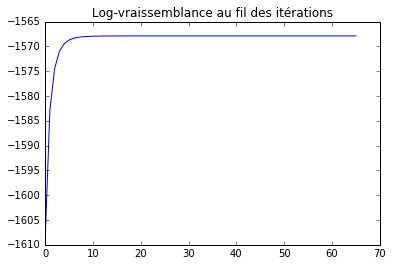

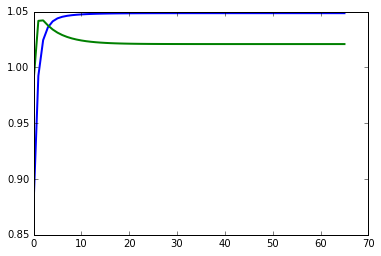

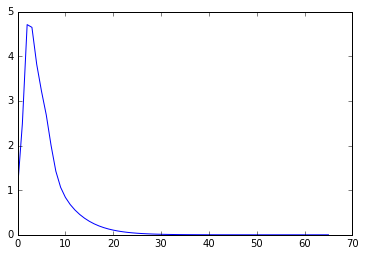

In [15]:
breast = model(10, 5)
breast.chargeData('Datasets/BreastCancer/DB_wdbc.csv')
breast.train(maxIter = 500, eta = 1, graphe = True)

In [113]:
print("LE SCORE D'ENTRAINEMENT EST DE : ", breast.score())
print("LE SCORE NAIF DE MOYENNE DES ANNOTATEURS EST DE : ", breast.scoreMoy())

LE SCORE D'ENTRAINEMENT EST DE :  0.534261384169
LE SCORE NAIF DE MOYENNE DES ANNOTATEURS EST DE :  0.887521968366


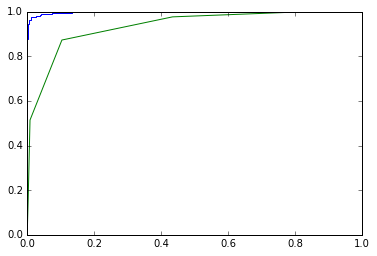

In [114]:
breast.roc()

ITERATION :  0
Vraissemblance :  [-1542.54762289]
Norme de diff_w :  7.77250450711
Alpha :  [array([ 0.91467452]), array([ 0.73997569]), array([ 0.55711638]), array([ 0.48666653]), array([ 0.1362019])]
Beta :  [array([ 0.1301761]), array([ 0.32687162]), array([ 0.55625972]), array([ 0.60974957]), array([ 0.89213904])]
ITERATION :  100
Vraissemblance :  [-1521.84698671]
Norme de diff_w :  0.0496395127976
Alpha :  [array([ 0.93697183]), array([ 0.59810576]), array([ 0.40627355]), array([ 0.34569296]), array([ 0.1124086])]
Beta :  [array([ 0.14489115]), array([ 0.21184669]), array([ 0.43138986]), array([ 0.49362934]), array([ 0.87180728])]


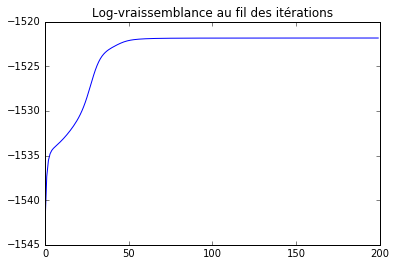

In [10]:
debug = model(11, 5)
debug.chargeData('Datasets/Debug.csv')
breast.train(maxIter = 200, eta = 1, graphe = True)

# TOUT CE QUI SUIT EST DU BROUILLON POUR LE DEVELOPPEMENT

In [3]:
d = 10  #descripteurs
N =  wine.shape[0] #produits à tester
R = 5 #experts

y = np.array(wine.ix[:,d+1:]) #labels des annotateurs
x = np.array(wine.ix[:,0:d]) #variables explicatives
w0 = np.random.rand(1,d)

In [4]:
x = (x -np.mean(x,axis=0))/(np.std(x, axis=0))

## Initialisation

In [6]:
def init_mu(y):
	mu = []
	for i in range(0,N):
		mu.append(np.sum(y[i])/R)
	return mu



mu0 = init_mu(y)

## Etape E

In [7]:
#E-step

def ai(alpha,y):
    a = []
    for i in range(0,N):
        proda = 1
        for j in range(0,R):
            proda = proda*alpha[j]**(y[i][j])*(1-alpha[j])**(1-y[i][j])
        a.append(proda)
    return a

def bi(beta,y):
    b = []
    for i in range(0,N):
        prodb = 1
        for j in range(0,R):
            prodb = prodb*beta[j]**(1-y[i][j])*(1-beta[j])**(y[i][j])
        b.append(prodb)
    return b

def pi(x,w):
    p = []
    for i in range(0,N):
        p.append(sigma(x[i].dot(w.T)))
    return p

def mui(a,b,p):
    mu = []
    for i in range(0,N):
        mu.append(a[i]*p[i]/(a[i]*p[i]+b[i]*(1-p[i])))
    return mu

def E_step(x,y,alpha,beta,w):
    CE = 0 #Conditionnal excepectation
    a = ai(alpha,y)
    b = bi(beta,y)
    p = pi(x,w)
    mu = mui(a,b,p)
    for i in range(0,N):
        CE += mu[i]*np.log(p[i])*a[i]+(1-mu[i])*np.log(1-p[i])*b[i]
    return mu

## Maximum Log - Likelihood Estimator

In [8]:
def logLikelihood(w, y, alpha, beta):
    a = ai(alpha, y)
    b = bi(beta, y)
    p = pi(x, w)
    
    #On calcule directement la log-vraissemblance.
    vraissemblance = 0
    for i in range(0,N):
        vraissemblance = vraissemblance + np.log((a[i]*p[i])+b[i]*(1-p[i]))
        
    return vraissemblance

## Étape M

In [9]:
#M-step

def alpha_function(mu,y):
	alpha = []
	for j in range(0,R):
		tmp1 = 0
		tmp2 = 0
		for i in range(0,N):
			tmp1 += mu[i]*y[i][j]
			tmp2 += mu[i]
		alpha.append(tmp1/tmp2)
	return alpha

def beta_function(mu,y):
    beta = []
    for j in range(0,R):
        tmp1 = 0
        tmp2 = 0
        for i in range(0,N):
            tmp1 += (1-mu[i])*(1-y[i][j])
            tmp2 += 1-mu[i]
        beta.append(tmp1/tmp2)
    return beta

def updateW(w,x, eta, mu):
    g = 0
    for i in range(0,N):
        g += (mu[i] - sigma(x[i].dot(w.T)))*x[i]
    
    H = np.zeros((d,d))
    for i in range(0,N):
        H -= sigma(x[i].dot(w.T))*(1-sigma(x[i].dot(w.T)))*((x[i].reshape(d,1))*(x[i].reshape(1,d)))
    w = w - eta*np.linalg.inv(H).dot(g)
    return w

In [10]:
updateW(w0,x,0.01,mu0)

array([[ 1.0712328 ,  0.68627885,  0.17959314,  0.5280033 ,  0.18660934,
         0.58655842,  0.8156623 ,  0.25828592,  0.80442013,  0.4460439 ]])

In [11]:
sigma(-x[0].dot(w0.T))

array([ 0.00014573])

## Itérations

In [12]:
mu = init_mu(y)
alpha = alpha_function(mu,y)
beta = beta_function(mu,y)
diff_w = 10
w = w0

compteur = 0

#while (np.linalg.norm(diff_w) > 0.001) : # Limite de convergence à decider
while (compteur < 1000):
    mu = E_step(x,y,alpha,beta,w)
    alpha = alpha_function(mu,y)
    beta = beta_function(mu,y)
    w_bis = updateW(w,x,0.01,mu)
    diff_w = w - w_bis
    w = w_bis
    if (compteur % 100 == 0):
        print ("ITERATION : ", compteur)
        print("Vraissemblance : ", logLikelihood(w, y, alpha, beta))
        print("Norme de diff_w : ", np.linalg.norm(diff_w))
        print("Alpha : ", alpha)
        print("Beta : ", beta)
    compteur = compteur + 1

ITERATION :  0
Vraissemblance :  [-1538.17487312]
Norme de diff_w :  0.07734278506
Alpha :  [array([ 0.91308806]), array([ 0.69729888]), array([ 0.5371915]), array([ 0.47191632]), array([ 0.13052233])]
Beta :  [array([ 0.1256996]), array([ 0.28960321]), array([ 0.53286485]), array([ 0.59151964]), array([ 0.88576052])]
ITERATION :  100
Vraissemblance :  [-1532.95810899]
Norme de diff_w :  0.0206209972087
Alpha :  [array([ 0.90177942]), array([ 0.65077594]), array([ 0.48379182]), array([ 0.41920836]), array([ 0.11272821])]
Beta :  [array([ 0.11687485]), array([ 0.255507]), array([ 0.49264057]), array([ 0.55188947]), array([ 0.87244708])]
ITERATION :  200
Vraissemblance :  [-1532.87417577]
Norme de diff_w :  0.0205847124017
Alpha :  [array([ 0.90226257]), array([ 0.64992699]), array([ 0.48382694]), array([ 0.41883142]), array([ 0.11258126])]
Beta :  [array([ 0.11722134]), array([ 0.25492741]), array([ 0.49267771]), array([ 0.55162603]), array([ 0.87234608])]
ITERATION :  300
Vraissemblanc